In [18]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [19]:
# Dictionary for emotion mapping based on filename structure
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


In [20]:
# Path to spectrogram images
path_to_save_spectrograms = 'C://Users//tatba//Downloads//Speech_Emotion_Detection(RCCIIT)//Speech_Emotion_Detection(RCCIIT) (2)//Speech_Emotion_Detection(RCCIIT)//Speech Emotion Detection//path_to_save_spectrograms'

In [21]:
# Image parameters
img_height, img_width = 128, 128

In [22]:
# Load images and labels from filenames
def load_data(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            # Load image manually using cv2
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (img_width, img_height))
            img_array = img / 255.0  # Normalize
            images.append(img_array)
            # Extract emotion from filename (3rd element in the filename)
            emotion_code = filename.split('-')[2]
            emotion_label = emotions[emotion_code]
            labels.append(emotion_label)
    return np.array(images), np.array(labels)

In [23]:
# Load the dataset
X, y = load_data(path_to_save_spectrograms)

In [24]:
# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [25]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [26]:
# Convert labels to categorical (one-hot encoding)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=8)

In [27]:
# Load the pre-trained DenseNet model without the top layer
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout layer
predictions = tf.keras.layers.Dense(8, activation='softmax')(x)

# Create the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [28]:
# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Train the model
history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - accuracy: 0.1992 - loss: 2.4027 - val_accuracy: 0.3125 - val_loss: 1.8511
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 538ms/step - accuracy: 0.2616 - loss: 1.8659 - val_accuracy: 0.3507 - val_loss: 1.7255
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 532ms/step - accuracy: 0.3682 - loss: 1.6787 - val_accuracy: 0.3993 - val_loss: 1.6697
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.3981 - loss: 1.5617 - val_accuracy: 0.3924 - val_loss: 1.6286
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - accuracy: 0.4135 - loss: 1.5757 - val_accuracy: 0.4340 - val_loss: 1.5538
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 562ms/step - accuracy: 0.4442 - loss: 1.4831 - val_accuracy: 0.4479 - val_loss: 1.4701
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 723ms/step - accuracy: 0.4380 - loss: 1.4836 - val_accuracy: 0.4549 - val_loss: 1.4521
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 590ms/step - accuracy: 0.4877 - loss: 1.4551 - 

In [30]:
# Get predictions
Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step


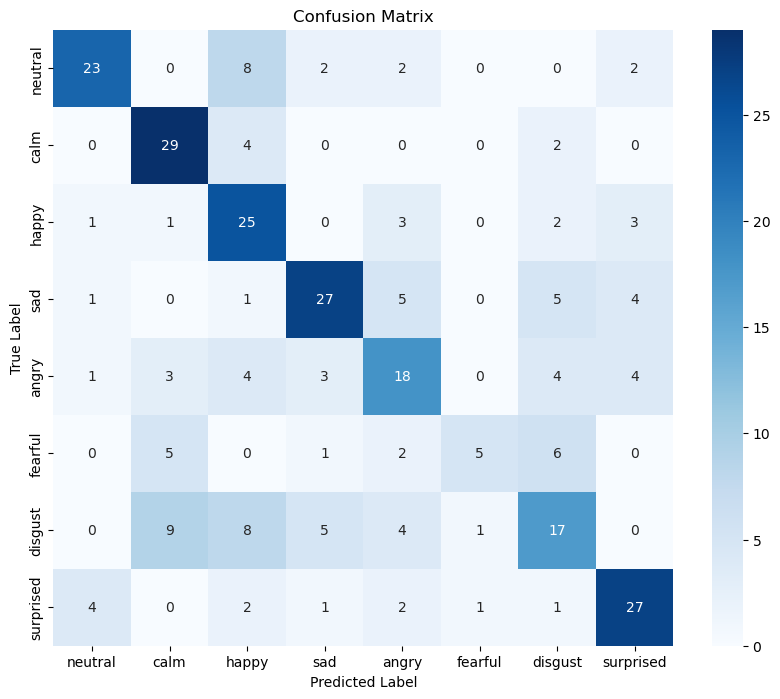

In [31]:
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = list(emotions.values())

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [32]:
# Generate classification report
report = classification_report(y_val, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

     neutral       0.77      0.62      0.69        37
        calm       0.62      0.83      0.71        35
       happy       0.48      0.71      0.57        35
         sad       0.69      0.63      0.66        43
       angry       0.50      0.49      0.49        37
     fearful       0.71      0.26      0.38        19
     disgust       0.46      0.39      0.42        44
   surprised       0.68      0.71      0.69        38

    accuracy                           0.59       288
   macro avg       0.61      0.58      0.58       288
weighted avg       0.61      0.59      0.59       288



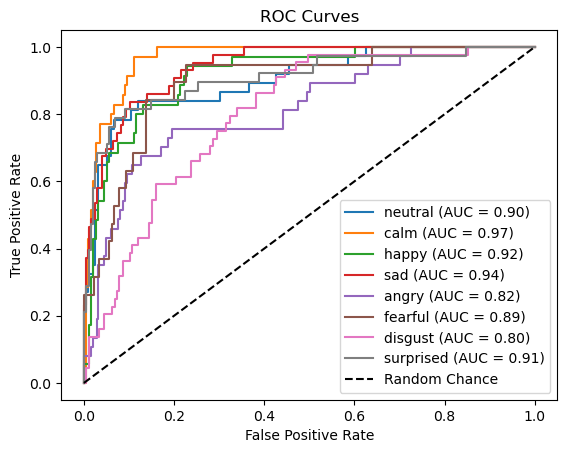

In [33]:
# Binarize labels for ROC-AUC
n_classes = len(labels)
y_val_bin = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()
